<a href="https://colab.research.google.com/github/dinaglamshowroom/projet-data_oc/blob/main/Projet5_NettoyageV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, glob
import pickle
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy import stats
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.metrics import pairwise_distances_argmin_min

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:

DATA_DIR = "/content/drive/MyDrive/Projet_5/Data"
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

print("Fichiers CSV trouv√©s :")
for f in csv_files:
    print(f)

Fichiers CSV trouv√©s :
/content/drive/MyDrive/Projet_5/Data/DisponibiliteÃÅ _viande_poulet_2022.csv
/content/drive/MyDrive/Projet_5/Data/DisponibiliteÃÅ_viande_poulet_2021.csv
/content/drive/MyDrive/Projet_5/Data/Population_2011_2021.csv
/content/drive/MyDrive/Projet_5/Data/PIB_2021.csv
/content/drive/MyDrive/Projet_5/Data/DisponibiliteÃÅ alimentiaire_totale_2021.csv
/content/drive/MyDrive/Projet_5/Data/disponibiliteÃÅ_elevage_2021.csv


In [9]:
dfs = {f.split("/")[-1]: pd.read_csv(f) for f in csv_files}

for name, df in dfs.items():
    print(f"{name}: {df.shape}")

DisponibiliteÃÅ _viande_poulet_2022.csv: (740, 15)
DisponibiliteÃÅ_viande_poulet_2021.csv: (740, 15)
Population_2011_2021.csv: (463, 15)
PIB_2021.csv: (381, 15)
DisponibiliteÃÅ alimentiaire_totale_2021.csv: (31144, 15)
disponibiliteÃÅ_elevage_2021.csv: (23660, 15)


In [19]:
df_dispo = dfs["DisponibiliteÃÅ_viande_poulet_2021.csv"]
df_PIB = dfs["PIB_2021.csv"]
df_pop = dfs["Population_2011_2021.csv"]
df_dispo_totale = dfs["DisponibiliteÃÅ alimentiaire_totale_2021.csv"]
df_dispo_elevage = dfs["disponibiliteÃÅ_elevage_2021.csv"]


In [20]:
# Extraire les ann√©es 2011 et 2021
pop = df_pop[df_pop["Ann√©e"].isin([2011, 2021])]

# Pivot table pour avoir colonnes 2011 / 2021 c√¥te √† c√¥te
pop_pivot = pop.pivot_table(index="Zone", columns="Ann√©e", values="Valeur").reset_index()
pop_pivot["pop_evo_ratio"] = ((pop_pivot[2021] - pop_pivot[2011]) / pop_pivot[2011]) * 100


In [21]:
prot_anim = df_dispo_elevage[
    df_dispo_elevage["√âl√©ment"].str.contains("prot√©ines", case=False)
]

prot_anim = prot_anim.groupby("Zone")["Valeur"].sum().reset_index()
prot_anim.columns = ["Pays", "proteines_anim_g_pers_jr"]


In [22]:
prot_tot = df_dispo_totale[
    df_dispo_totale["√âl√©ment"].str.contains("prot√©ines", case=False)
]

prot_tot = prot_tot.groupby("Zone")["Valeur"].sum().reset_index()
prot_tot.columns = ["Pays", "proteines_total_g_pers_jr"]


In [23]:
prot_anim = df_dispo_elevage[
    df_dispo_elevage["√âl√©ment"].str.contains("prot√©ines", case=False)
]

prot_anim = prot_anim.groupby("Zone")["Valeur"].sum().reset_index()
prot_anim.columns = ["Pays", "proteines_anim_g_pers_jr"]


In [24]:
prot = prot_tot.merge(prot_anim, on="Pays", how="inner")
prot["part_prot_anim"] = prot["proteines_anim_g_pers_jr"] / prot["proteines_total_g_pers_jr"]


In [25]:
kcal = df_dispo_totale[
    df_dispo_totale["√âl√©ment"].str.contains("Kcal", case=False)
]

kcal = kcal.groupby("Zone")["Valeur"].sum().reset_index()
kcal.columns = ["Pays", "kcal_total_pers_jr"]


In [26]:
# Fusion successive
df_X = prot.merge(kcal, on="Pays", how="inner")
df_X = df_X.merge(pop_pivot[["Zone", "pop_evo_ratio"]].rename(columns={"Zone": "Pays"}), on="Pays", how="inner")


In [67]:
pib = df_PIB[df_PIB["Produit"].str.contains("PIB", case=False)][["Zone", "Valeur"]]
pib.columns = ["Pays", "pib_par_habitant"]
df_X = df_X.merge(pib, on="Pays", how="left")


In [68]:
df_X.duplicated().sum()

np.int64(0)

In [31]:
df_X.isna().sum()

Pays                         0
proteines_total_g_pers_jr    0
proteines_anim_g_pers_jr     0
part_prot_anim               0
kcal_total_pers_jr           0
pop_evo_ratio                2
pib_par_habitant             8
dtype: int64

In [33]:
df_X_clean = df_X.replace([np.inf, -np.inf], np.nan).dropna()

In [69]:
df_X_clean = df_X_clean.reset_index(drop=True)

In [35]:
df_X_clean.info()
df_X_clean.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Pays                       178 non-null    object 
 1   proteines_total_g_pers_jr  178 non-null    float64
 2   proteines_anim_g_pers_jr   178 non-null    float64
 3   part_prot_anim             178 non-null    float64
 4   kcal_total_pers_jr         178 non-null    float64
 5   pop_evo_ratio              178 non-null    float64
 6   pib_par_habitant           178 non-null    float64
dtypes: float64(6), object(1)
memory usage: 9.9+ KB


proteines_total_g_pers_jr  proteines_anim_g_pers_jr  part_prot_anim  \
count                 178.000000                178.000000      178.000000   
mean                   89.276348                 38.077022        0.393659   
std                    23.898614                 22.219035        0.164390   
min                    29.550000                  2.100000        0.058867   
25%                    71.202500                 17.387500        0.260989   
50%                    90.990000                 37.215000        0.412521   
75%                   108.640000                 56.457500        0.533319   
max                   150.710000                 92.500000        0.694235   

       kcal_total_pers_jr  pop_evo_ratio  pib_par_habitant  
count          178.000000     178.000000        178.000000  
mean          2938.732584      14.615604      23405.771348  
std            465.094502      14.231541      24153.165736  
min           1771.730000     -20.305546        836.700000  
25%           2617.352500       3.919512       5761.525000  
50%           2958.650000      12.974246      15289.350000  
75%           3297.652500      24.610461      33384.875000  
max           3898.190000      55.442282     136772.000000

In [102]:
df_main = df_X_clean[[
    "pop_evo_ratio",
    "proteines_total_g_pers_jr",
    "part_prot_anim",
    "kcal_total_pers_jr",
    'Pays'
]]


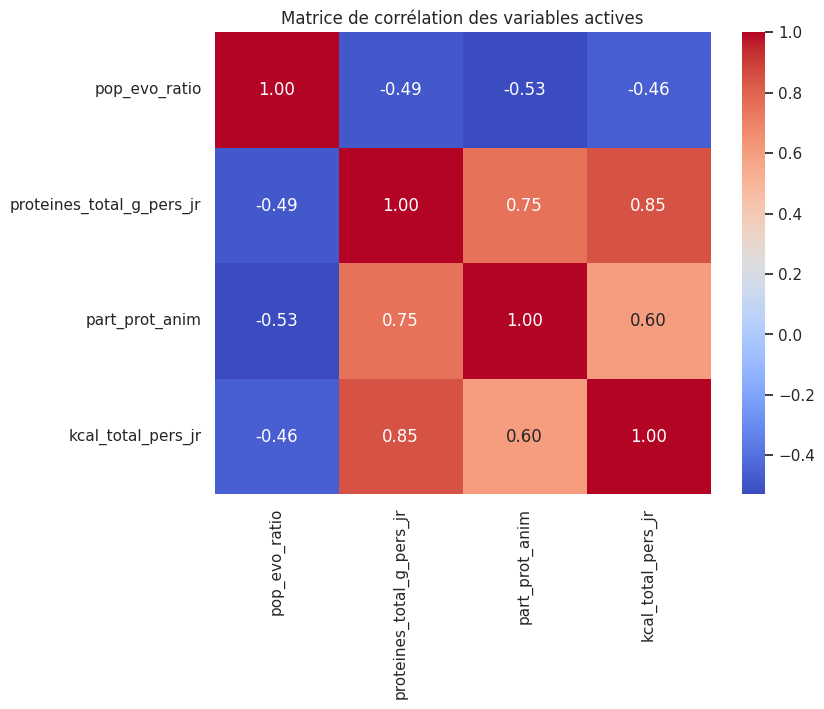

In [103]:
corr_df = df_main.copy()
if 'Pays' in corr_df.columns:
    corr_df = corr_df.drop(columns=["Pays"])

# Calcul de la matrice de corr√©lation
corr = corr_df.corr()

# Affichage de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corr√©lation des variables actives")
plt.show()

* Forte corr√©lation : kcal_total_pers_jr - proteines_total_g_pers_jr (r = 0.85)

 * part_prot_anim bien li√©e aux prot√©ines totales (r = 0.75)

* pop_evo_ratio mod√©r√©ment n√©gatif avec les autres variables (~ -0.5)

Redondance potentielle entre calories et prot√©ines totales?

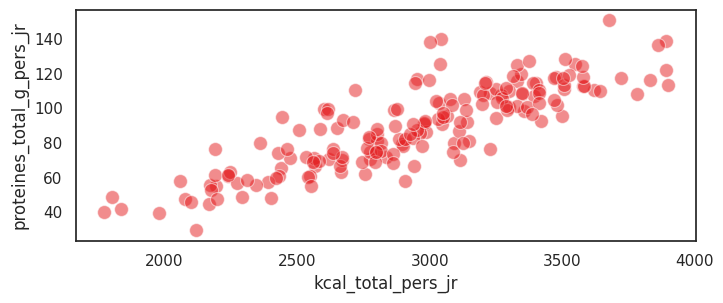

In [104]:
plt.figure(figsize=(8, 3))
sns.scatterplot(data=df_main, x='kcal_total_pers_jr', y='proteines_total_g_pers_jr', s=100, alpha=.5)
sns.set_theme(style="white", palette="Set2")
plt.show()


* Relation quasi-lin√©aire

* Logique nutritionnelle respect√©e

* Risque de redondance avec deux variables tr√®s proches

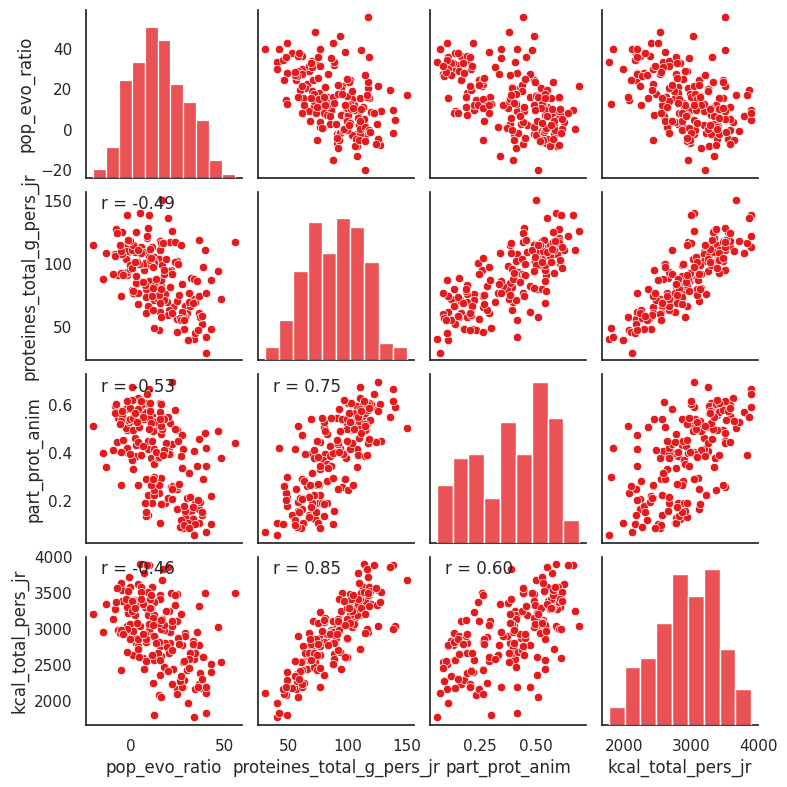

In [105]:
def corrfunc(x, y, **kwargs):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f"r = {r:.2f}", xy=(.1, .9), xycoords=ax.transAxes)

# üß™ S√©lection des colonnes num√©riques (et suppression √©ventuelle de "Pays")
corr_df = df_main.select_dtypes(include='number')

# üìä Param√®tres de style
sns.set_context('notebook', font_scale=0.9)
sns.set_theme(style="white", palette="Set1")

# üîç Cr√©ation du pairplot avec corr√©lations annot√©es
g = sns.pairplot(corr_df, height=2)
g.map_lower(corrfunc)



plt.show()

* Sont visuellement diff√©renci√©s, surtout selon pop_evo_ratio

* Corr√©lations lin√©aires visibles, peu de valeurs aberrantes

* part_prot_anim : bonne variabilit√©

# Classification Hierarchique Ascendante

In [107]:
df_dendo =df_main.set_index('Pays')

In [108]:
Z = linkage(df_dendo, method = 'ward')

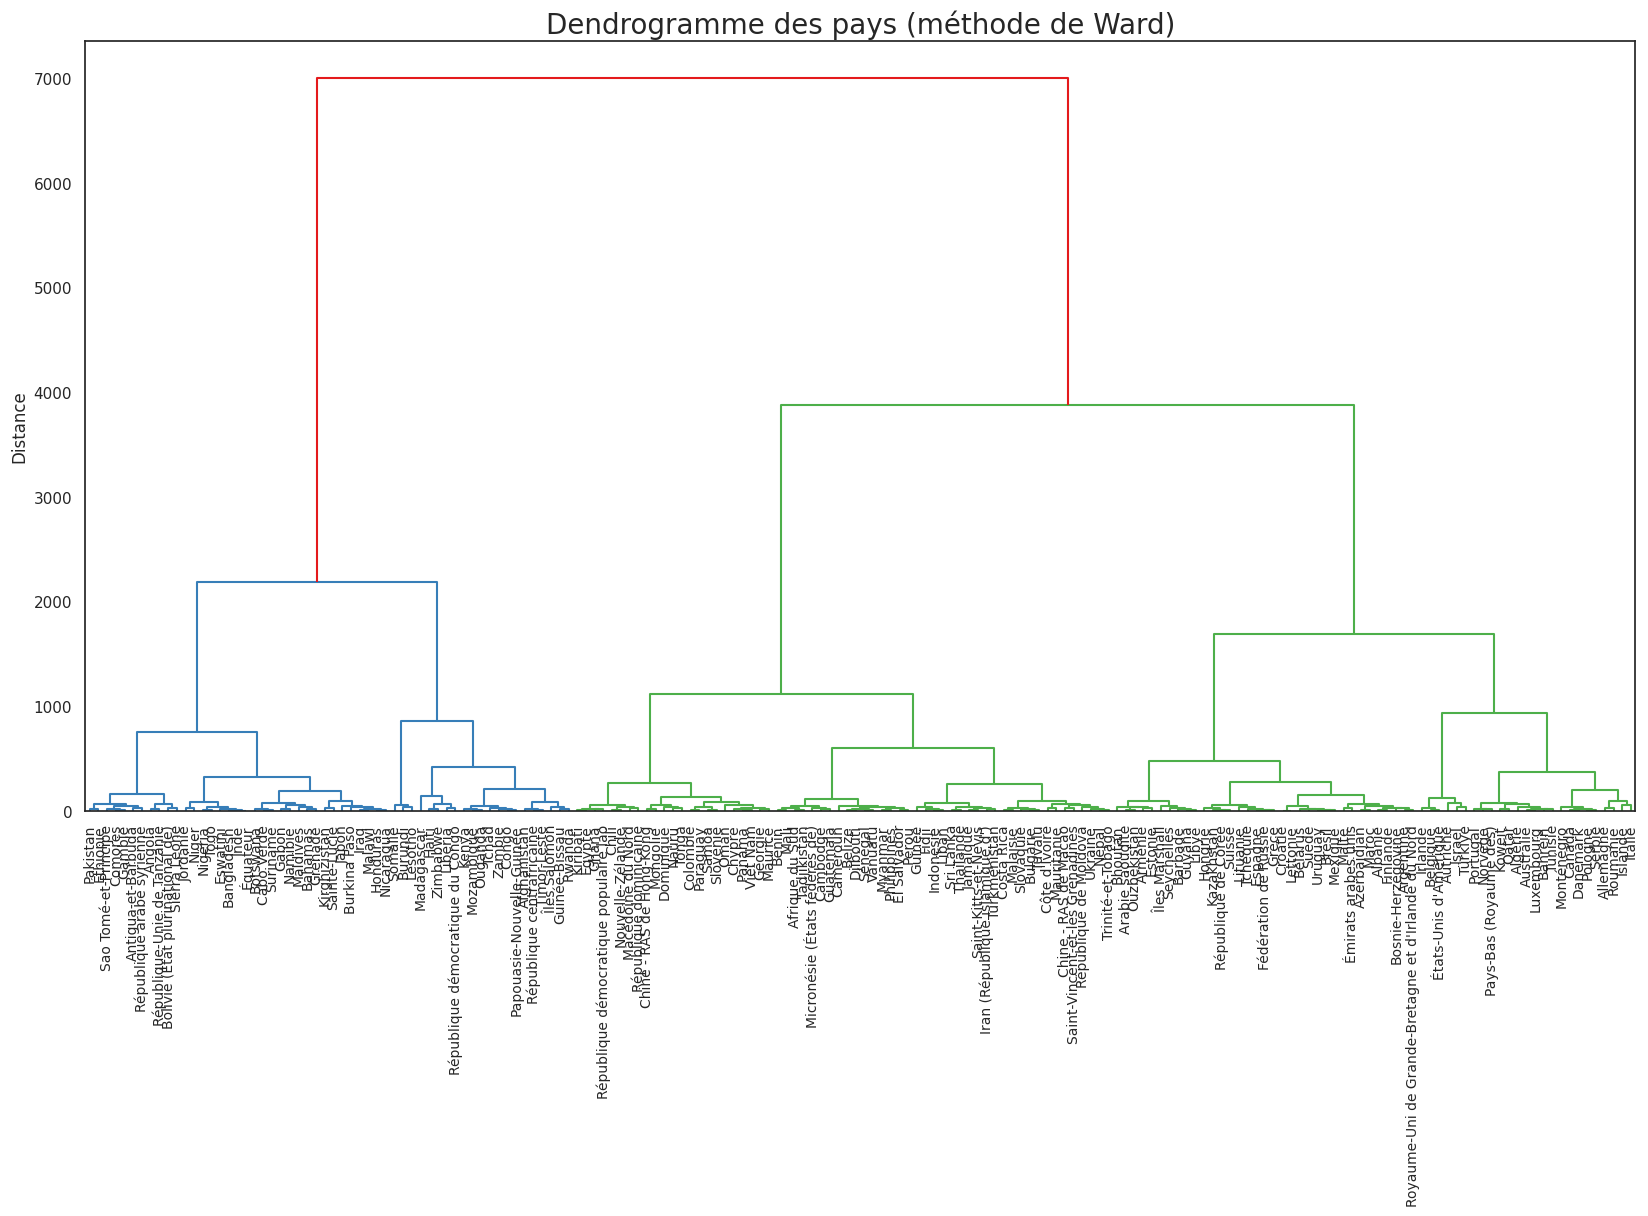

In [109]:
plt.figure(figsize=(20, 10))
sns.set_style('white')
plt.title('Dendrogramme des pays (m√©thode de Ward)', fontsize=20)
plt.ylabel('Distance', fontsize=12)

dendrogram(Z, labels=df_dendo.index, leaf_font_size=10, orientation='top')
plt.savefig("dendrogramme.png")
plt.show()


graphe de l'inertie expliqu√©e en fonction du nombre de clustergraphe de l'inertie expliqu√©e en fonction du nombre de cluster


In [122]:
X = df_dendo.values
X.shape

(178, 4)

In [123]:
scale = preprocessing.StandardScaler().fit(X)
X_scaled = scale.transform(X)

In [124]:


# On suppose que `X_scaled` est d√©j√† cr√©√© (donn√©es standardis√©es)
Z = linkage(X_scaled, method='ward')

# Calcul de l'inertie pour k = 2 √† 20
K = range(2, 25)
inertie = []

In [125]:
# Calcul de l'inertie pour k = 2 √† 20
K = range(2, 25)
inertie = []

for k in K:
    labels = fcluster(Z, t=k, criterion='maxclust')

    # Calcul de l'inertie : somme des distances aux centro√Ødes
    groupes = [X[labels == i] for i in range(1, k+1)]
    inertie_k = 0
    for group in groupes:
        if len(group) > 0:
            center = group.mean(axis=0)
            dists = ((group - center) ** 2).sum()
            inertie_k += dists
    inertie.append(inertie_k)

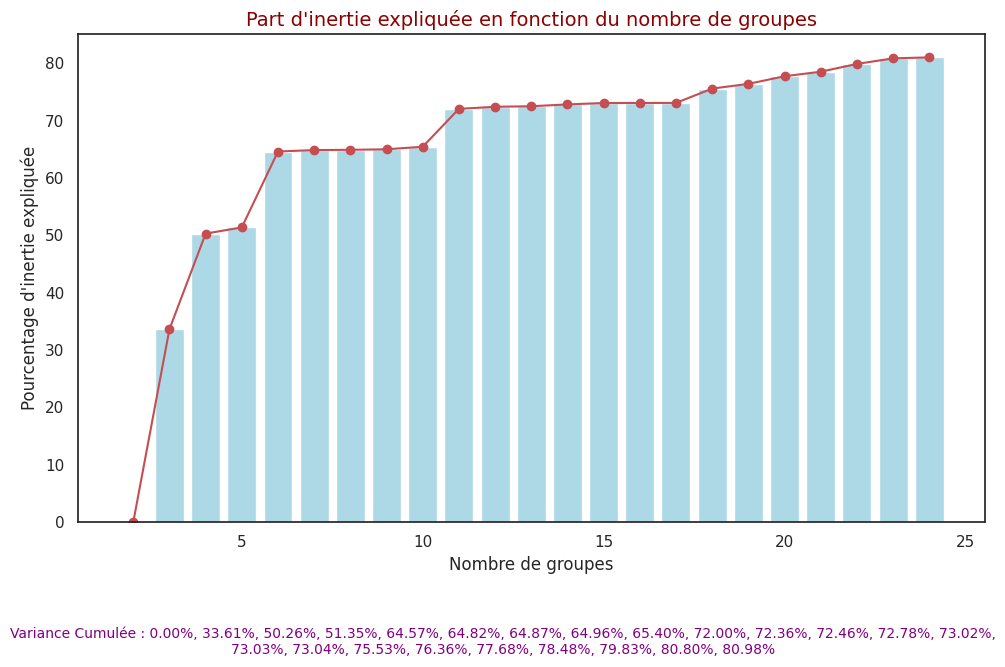

In [129]:
# Pourcentage d'inertie expliqu√©e
inertie_totale = inertie[0]  # l'inertie avec k=2 sert de base
inertie_expliquee = [100 * (1 - i / inertie[0]) for i in inertie]

# Trac√©
plt.figure(figsize=(10, 6))
plt.bar(K, inertie_expliquee, color='lightblue')
plt.plot(K, inertie_expliquee, 'o-r')
plt.title("Part d'inertie expliqu√©e en fonction du nombre de groupes", fontsize=14, color='darkred')
plt.xlabel("Nombre de groupes")
plt.ylabel("Pourcentage d'inertie expliqu√©e")

# Annotation de la variance cumul√©e
text = "Variance Cumul√©e : " + ", ".join([f"{v:.2f}%" for v in inertie_expliquee])
plt.figtext(0.5, -0.1, text, wrap=True, horizontalalignment='center', fontsize=10, color='purple')
plt.tight_layout()
plt.show()

passons au d√©coupage

In [145]:
from scipy.cluster.hierarchy import fcluster

# Coupe du dendrogramme pour former 5 groupes
clusters = fcluster(Z, t=5, criterion='maxclust')

In [147]:
from scipy.cluster.hierarchy import fcluster

# D√©coupage en 5 clusters √† partir de la matrice de linkage Z
clusters = fcluster(Z, t=5, criterion='maxclust')

# Ajout des labels de cluster au DataFrame initial
df_dendo.loc[:, "cluster"] = clusters



# V√©rification rapide : combien de pays dans chaque groupe ?
df_dendo["cluster"].value_counts().sort_index()


cluster
1    47
2    48
3    28
4    22
5    33
Name: count, dtype: int64

In [148]:
for i in range(1, 6):
    print(f"Cluster {i}:")
    print(", ".join(df_dendo[df_dendo["cluster"] == i].index.sort_values()))
    print()


Cluster 1:
Afghanistan, Angola, Burkina Faso, Burundi, B√©nin, Cameroun, Comores, Congo, C√¥te d'Ivoire, Gabon, Gambie, Ghana, Guin√©e, Guin√©e-Bissau, Ha√Øti, Iraq, Jordanie, Kenya, Lesotho, Lib√©ria, Madagascar, Malawi, Maldives, Mali, Mauritanie, Mozambique, Namibie, Niger, Nig√©ria, Ouganda, Papouasie-Nouvelle-Guin√©e, Rwanda, R√©publique d√©mocratique du Congo, R√©publique-Unie de Tanzanie, Sao Tom√©-et-Principe, Sierra Leone, Somalie, S√©n√©gal, Tadjikistan, Tchad, Timor-Leste, Togo, Vanuatu, Zambie, Zimbabwe, √âthiopie, √éles Salomon

Cluster 2:
Albanie, Allemagne, Argentine, Arm√©nie, Australie, Autriche, Barbade, Belgique, Bosnie-Herz√©govine, Br√©sil, B√©larus, Canada, Chine - RAS de Hong-Kong, Chine - RAS de Macao, Croatie, Danemark, Espagne, Estonie, Finlande, F√©d√©ration de Russie, Gr√®ce, Hongrie, Irlande, Islande, Isra√´l, Italie, Kazakhstan, Lettonie, Lituanie, Luxembourg, Mongolie, Mont√©n√©gro, Nauru, Norv√®ge, Pays-Bas (Royaume des), Pologne, Portugal, Roumanie, Roy

In [149]:
df_dendo.groupby("cluster").mean(numeric_only=True)


pop_evo_ratio  proteines_total_g_pers_jr  part_prot_anim  \
cluster                                                             
1            30.817414                  62.565957        0.217585   
2             4.060292                 116.255000        0.561977   
3            19.238237                 100.267143        0.427839   
4            -0.564180                  93.313636        0.471248   
5            13.091102                  76.059697        0.318878   

         kcal_total_pers_jr  
cluster                      
1               2422.164043  
2               3431.101042  
3               3236.001071  
4               2877.582727  
5               2746.817879